<a href="https://colab.research.google.com/github/kanta0410/stock_price/blob/main/stock4_fear_and_greed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3084620996.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="10y", interval="1d")['Close']
[*********************100%***********************]  2 of 2 completed


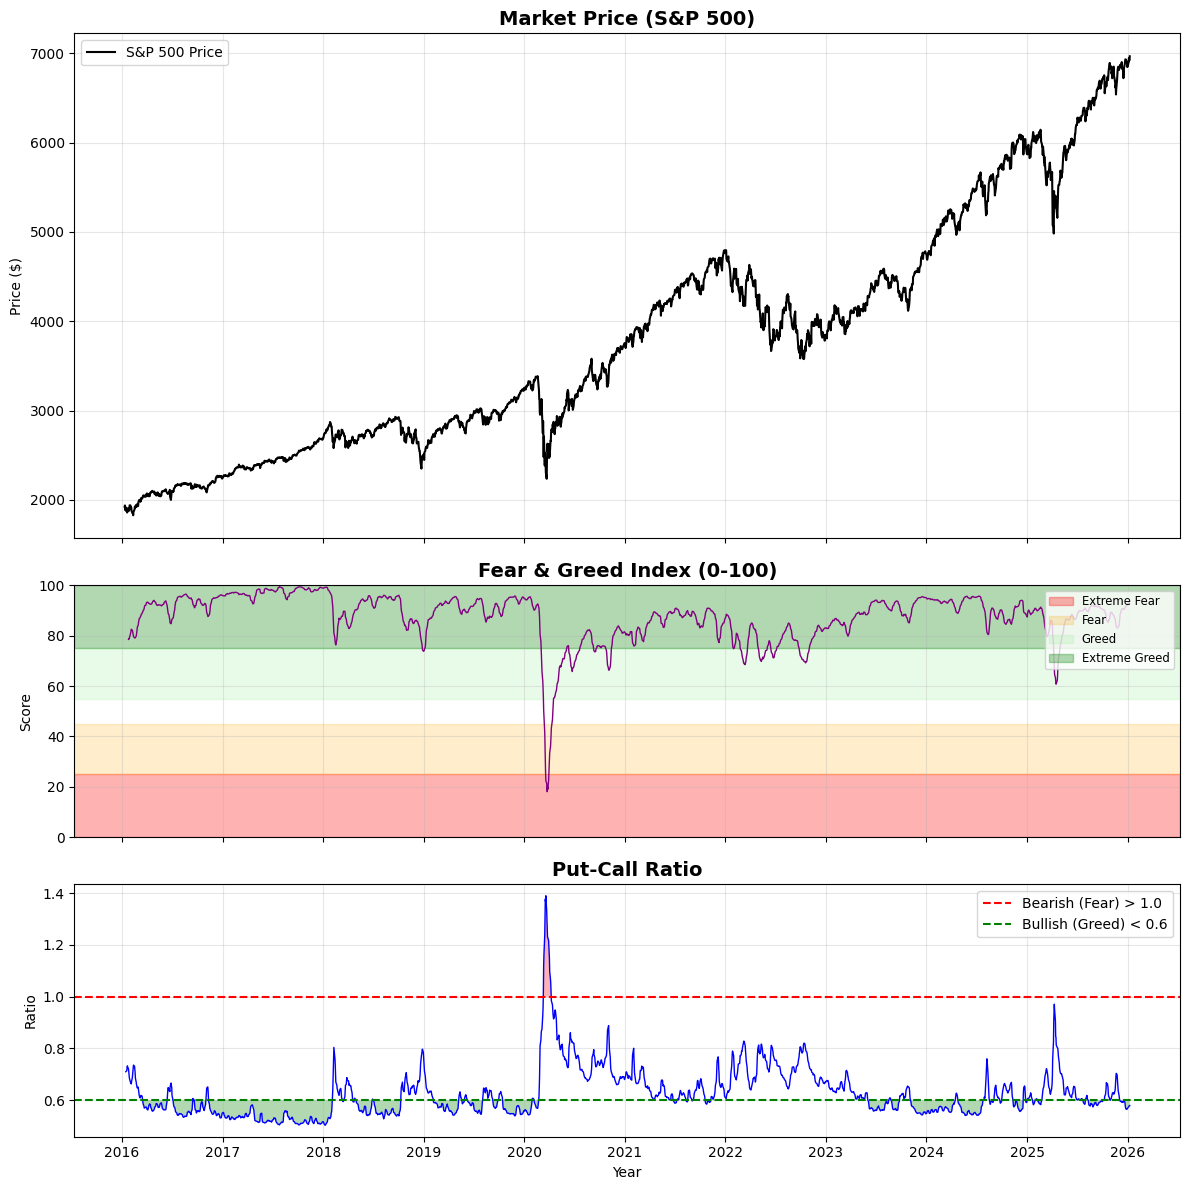

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# 1. データの取得 (過去10年分)
# ^GSPC: S&P 500 (市場全体の動き)
# ^VIX: VIX指数 (恐怖指数の代用として使用)
tickers = ["^GSPC", "^VIX"]
data = yf.download(tickers, period="10y", interval="1d")['Close']

# データの整理
df = data.copy()
df.columns = ['S&P500', 'VIX']
df = df.dropna()

# 2. 指標のシミュレーション (デモ用)
# ※実際のデータをCSVでお持ちの場合は、ここを読み込み処理に書き換えてください。

# Fear & Greed Index の近似 (VIXと逆相関する傾向があるため、VIXから算出)
# VIXが高い(恐怖)と指数は低くなり、VIXが低い(安心)と指数は高くなる
# 0-100の範囲に正規化
df['Simulated_Fear_Greed'] = 100 - ((df['VIX'] - df['VIX'].min()) / (df['VIX'].max() - df['VIX'].min()) * 100)
# 移動平均をかけて滑らかにする（実際の指数に近づける）
df['Simulated_Fear_Greed'] = df['Simulated_Fear_Greed'].rolling(window=10).mean()

# Put-Call Ratio の近似 (VIXと正の相関がある傾向)
# VIXが高いとPCRも高くなる（プットが買われるため）
df['Simulated_PCR'] = 0.5 + ((df['VIX'] - df['VIX'].min()) / (df['VIX'].max() - df['VIX'].min()) * 1.0)
df['Simulated_PCR'] = df['Simulated_PCR'].rolling(window=5).mean()


# 3. 可視化 (一目でわかる図解)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})

# --- 上段: S&P 500 (市場価格) ---
ax1.plot(df.index, df['S&P500'], color='black', linewidth=1.5, label='S&P 500 Price')
ax1.set_title('Market Price (S&P 500)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# --- 中段: Fear and Greed Index (恐怖と強欲) ---
ax2.plot(df.index, df['Simulated_Fear_Greed'], color='purple', linewidth=1)
ax2.set_title('Fear & Greed Index (0-100)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_ylim(0, 100)

# 色分け (背景)
# 0-25: Extreme Fear (濃い赤), 25-45: Fear (薄い赤)
# 45-55: Neutral (白/グレー), 55-75: Greed (薄い緑), 75-100: Extreme Greed (濃い緑)
ax2.axhspan(0, 25, color='red', alpha=0.3, label='Extreme Fear')
ax2.axhspan(25, 45, color='orange', alpha=0.2, label='Fear')
ax2.axhspan(55, 75, color='lightgreen', alpha=0.2, label='Greed')
ax2.axhspan(75, 100, color='green', alpha=0.3, label='Extreme Greed')
ax2.legend(loc='upper right', fontsize='small')
ax2.grid(True, alpha=0.3)

# --- 下段: Put-Call Ratio (プット・コール・レシオ) ---
ax3.plot(df.index, df['Simulated_PCR'], color='blue', linewidth=1)
ax3.set_title('Put-Call Ratio', fontsize=14, fontweight='bold')
ax3.set_ylabel('Ratio')

# 基準線
ax3.axhline(1.0, color='red', linestyle='--', linewidth=1.5, label='Bearish (Fear) > 1.0')
ax3.axhline(0.6, color='green', linestyle='--', linewidth=1.5, label='Bullish (Greed) < 0.6')
ax3.fill_between(df.index, df['Simulated_PCR'], 1.0, where=(df['Simulated_PCR'] >= 1.0), facecolor='red', alpha=0.3)
ax3.fill_between(df.index, df['Simulated_PCR'], 0.6, where=(df['Simulated_PCR'] <= 0.6), facecolor='green', alpha=0.3)
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# 全体の設定
plt.xlabel('Year')
plt.tight_layout()

# 画像として保存
plt.savefig('market_sentiment_analysis.png')

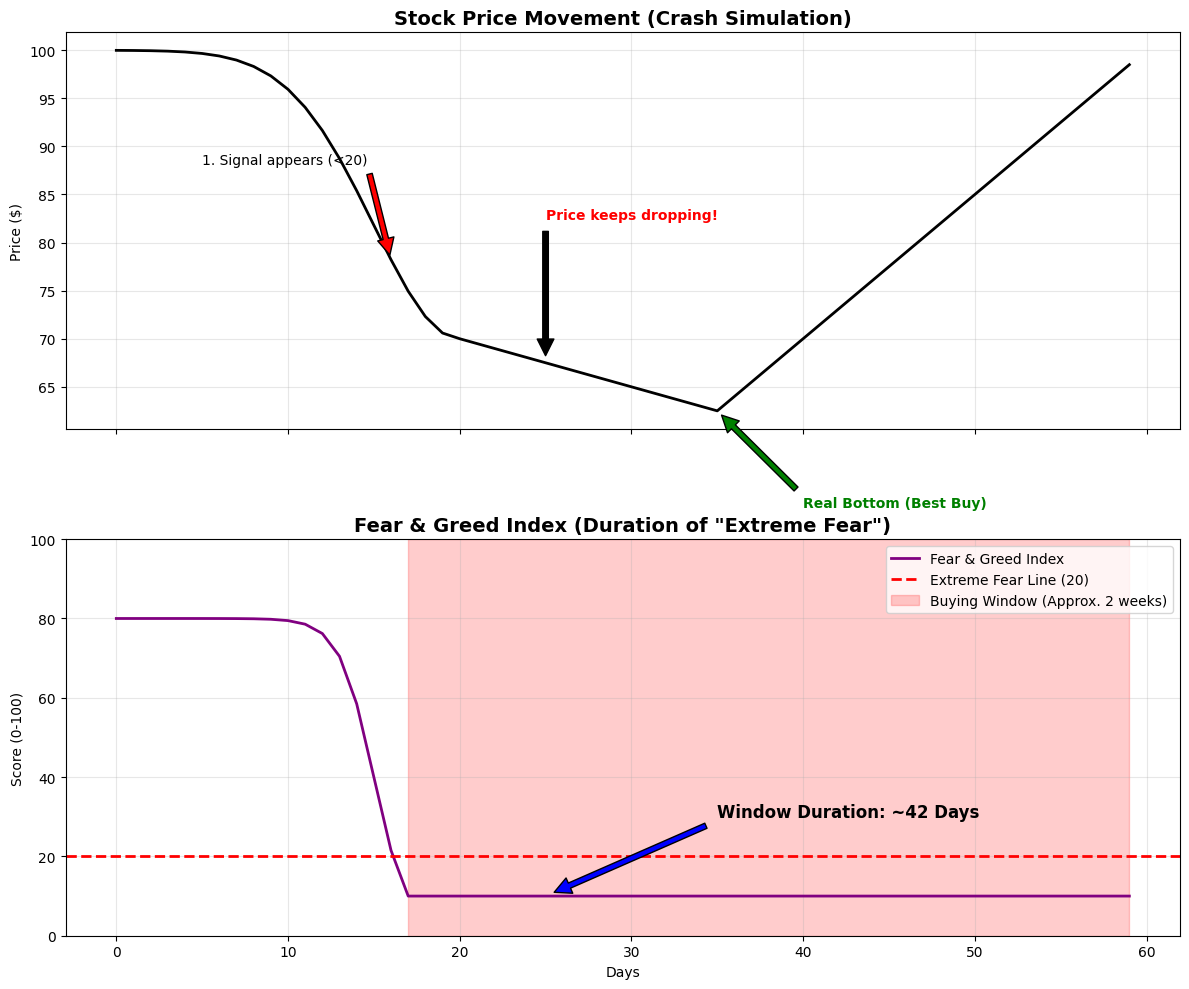

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# データのシミュレーション（典型的な暴落と回復のパターンを作成）
days = np.arange(0, 60)
# 株価: 最初は横ばい、急落し、底を這ってから回復する
price = 100 - (30 * np.exp(-0.5 * ((days - 20) / 5)**2))  # 暴落モデル
price[20:] = price[20] - (days[20:] - 20) * 0.5 # 底が抜けてさらに下がる動きを追加（ダマシ）
price[35:] = price[35] + (days[35:] - 35) * 1.5 # 本当の回復

# 恐怖指数（Fear & Greed）: 株価暴落時に急落し、底圏で張り付く
# 100からスタートし、暴落時に10程度まで下がる
fear_index = 50 + 40 * np.tanh((days - 15) / 2) # 元の動き
fear_index = 100 - (fear_index + 10) # 反転させて恐怖指数っぽくする（低いほど恐怖）
fear_index = np.clip(fear_index, 10, 80) # 範囲制限

# グラフ化
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- 上段: 株価の動き ---
ax1.plot(days, price, color='black', linewidth=2, label='Stock Price')
ax1.set_title('Stock Price Movement (Crash Simulation)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# 罠（早すぎる買い）と本当の底
ax1.annotate('1. Signal appears (<20)', xy=(16, price[16]), xytext=(5, price[16]+10),
             arrowprops=dict(facecolor='red', shrink=0.05))
ax1.annotate('Price keeps dropping!', xy=(25, price[25]), xytext=(25, price[25]+15),
             arrowprops=dict(facecolor='black', shrink=0.05), color='red', fontweight='bold')
ax1.annotate('Real Bottom (Best Buy)', xy=(35, price[35]), xytext=(40, price[35]-10),
             arrowprops=dict(facecolor='green', shrink=0.05), color='green', fontweight='bold')

# --- 下段: Fear & Greed Index (恐怖指数) ---
ax2.plot(days, fear_index, color='purple', linewidth=2, label='Fear & Greed Index')
ax2.set_title('Fear & Greed Index (Duration of "Extreme Fear")', fontsize=14, fontweight='bold')
ax2.set_ylabel('Score (0-100)')
ax2.set_ylim(0, 100)
ax2.axhline(20, color='red', linestyle='--', linewidth=2, label='Extreme Fear Line (20)')

# 恐怖期間（チャンス期間）の塗りつぶし
fear_zone = fear_index <= 20
ax2.fill_between(days, 0, 100, where=fear_zone, color='red', alpha=0.2, label='Buying Window (Approx. 2 weeks)')

# 期間の表示
start_fear = np.where(fear_zone)[0][0]
end_fear = np.where(fear_zone)[0][-1]
duration = end_fear - start_fear
ax2.annotate(f'Window Duration: ~{duration} Days', xy=(25, 10), xytext=(35, 30),
             arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=12, fontweight='bold')

ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.xlabel('Days')
plt.tight_layout()
plt.savefig('fear_duration_trap.png')

チャートを生成しました。


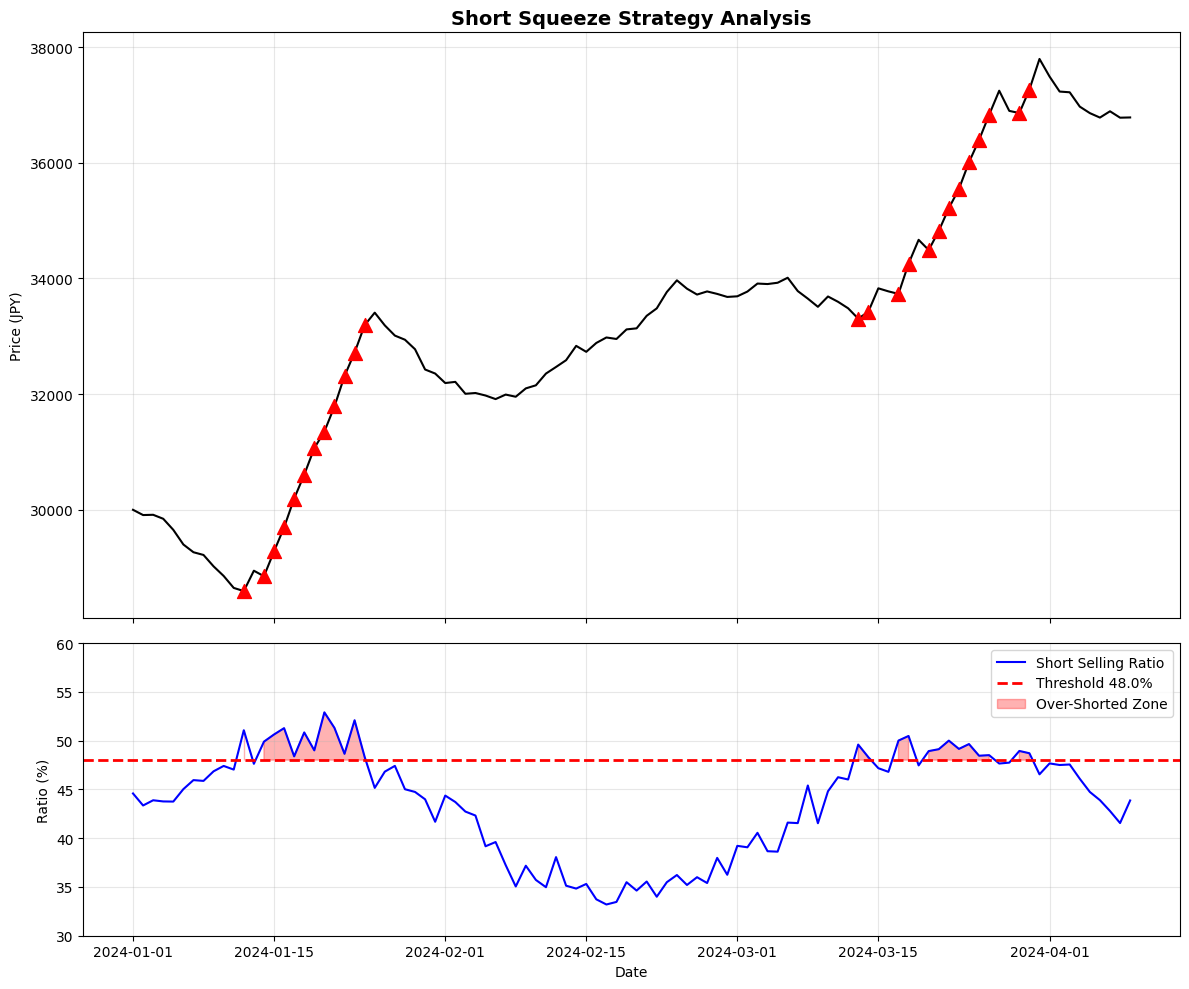

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# 1. データの準備 (シミュレーション)
# ---------------------------------------------------------
# 日数
days = 100
date_range = pd.date_range(start='2024-01-01', periods=days)

# 空売り比率のシミュレーション
# 通常は40%前後。50%に近づくと「売りすぎ(過熱)」。
# サイン波を使って、周期的に「売りが殺到する場面」を作る
short_ratio = 42 + 8 * np.sin(np.linspace(0, 3 * np.pi, days))
# ランダムなノイズを加える
short_ratio += np.random.normal(0, 1.5, days)

# 株価のシミュレーション
# 空売り比率が高いときは株価が下がり、限界を超えると急騰（買い戻し）する動きを作る
price = 30000 * np.ones(days)
trend = 0
for i in range(1, days):
    # 空売り比率が高い(=売り圧力)と株価は下がりやすいが...
    if short_ratio[i-1] < 48:
        change = - (short_ratio[i-1] - 40) * 20 # 売り圧で下がる
    else:
        # 空売り比率が48%を超えると、逆に「買い戻し」で急騰する(ショートスクイズ)
        change = + 400 # 強烈なリバウンド

    trend += change + np.random.normal(0, 100) # ノイズ
    price[i] += trend

df = pd.DataFrame({
    'Date': date_range,
    'Price': price,
    'Short_Ratio': short_ratio
})
df.set_index('Date', inplace=True)

# ---------------------------------------------------------
# 2. 売買シグナルの定義 (ご希望の理論)
# ---------------------------------------------------------
# 「空売りの個数が減ってきたら(=空売り比率が異常に高いなら) 注文を出す」
# 基準: 空売り比率が 48% を超えたら「買いシグナル」とする
THRESHOLD_RATIO = 48.0

df['Buy_Signal'] = df['Short_Ratio'] > THRESHOLD_RATIO

# ---------------------------------------------------------
# 3. 可視化 (チャート行動の分析)
# ---------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True,
                               gridspec_kw={'height_ratios': [2, 1]})

# --- 上段: 株価チャート ---
ax1.plot(df.index, df['Price'], label='Nikkei 225 (Simulated)', color='black')
ax1.set_ylabel('Price (JPY)')
ax1.set_title('Short Squeeze Strategy Analysis', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 買いシグナルのポイントをプロット
buy_dates = df[df['Buy_Signal']].index
buy_prices = df[df['Buy_Signal']]['Price']
ax1.scatter(buy_dates, buy_prices, color='red', marker='^', s=100, label='Buy Signal (Short Squeeze)', zorder=5)

# --- 下段: 空売り比率 (Short Selling Ratio) ---
ax2.plot(df.index, df['Short_Ratio'], label='Short Selling Ratio', color='blue')
ax2.set_ylabel('Ratio (%)')
ax2.set_xlabel('Date')
ax2.set_ylim(30, 60) # 日本市場の一般的なレンジ

# 基準線 (48%以上は異常値)
ax2.axhline(THRESHOLD_RATIO, color='red', linestyle='--', linewidth=2, label=f'Threshold {THRESHOLD_RATIO}%')
ax2.fill_between(df.index, df['Short_Ratio'], THRESHOLD_RATIO,
                 where=(df['Short_Ratio'] >= THRESHOLD_RATIO),
                 color='red', alpha=0.3, label='Over-Shorted Zone')

ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('short_selling_analysis.png')
print("チャートを生成しました。")

/tmp/ipython-input-1882583751.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(tickers.keys()), period="2y", interval="1d")['Close']
[*********************100%***********************]  6 of 6 completed


6銘柄の分析チャートを作成しました。


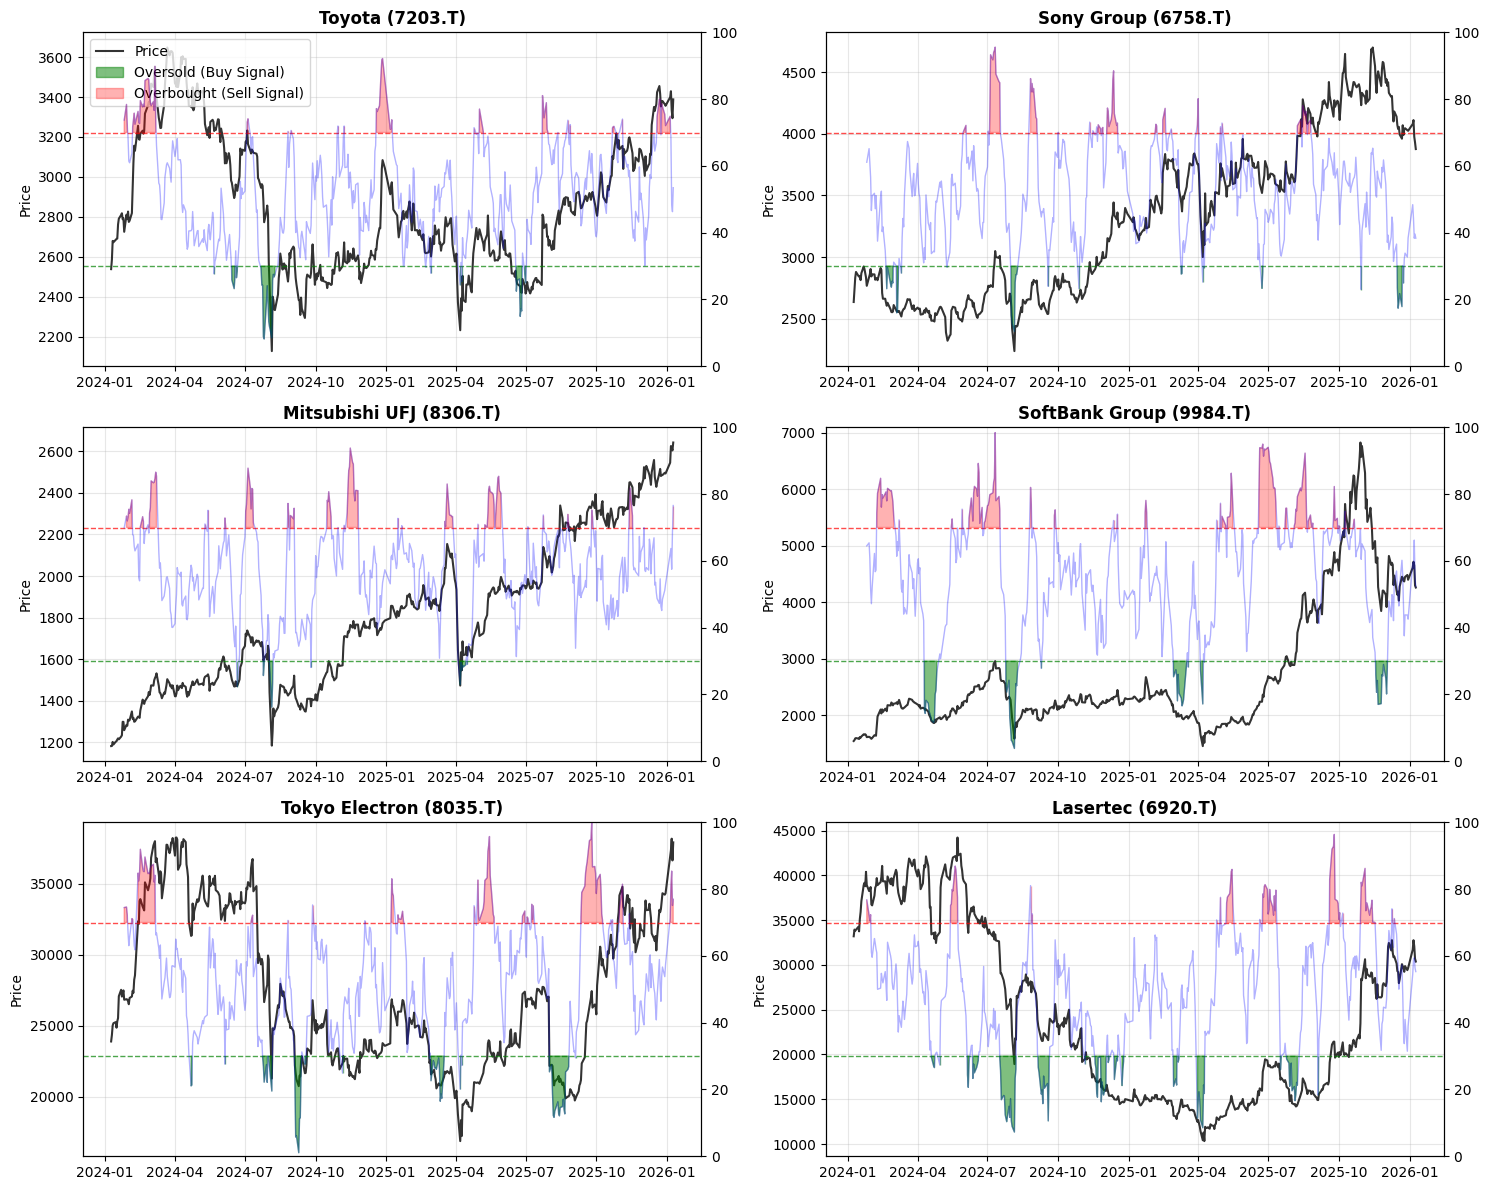

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 1. 銘柄リスト (ティッカーシンボル)
tickers = {
    "7203.T": "Toyota",
    "6758.T": "Sony Group",
    "8306.T": "Mitsubishi UFJ",
    "9984.T": "SoftBank Group",
    "8035.T": "Tokyo Electron",
    "6920.T": "Lasertec"
}

# 2. データ取得 (過去2年分)
# ※期間を長くしすぎると直近の動きが見えにくくなるため2年に設定
data = yf.download(list(tickers.keys()), period="2y", interval="1d")['Close']

# 3. RSI (Fear & Greedの代用) の計算関数
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 4. グラフ化 (2行3列で表示)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (ticker, name) in enumerate(tickers.items()):
    ax = axes[i]

    # 株価データの抽出
    price = data[ticker]
    rsi = calculate_rsi(price)

    # --- 株価チャート (上半分) ---
    # 軸を共有するために twinx を使用
    ax_rsi = ax.twinx()

    # 株価プロット
    ax.plot(price.index, price, color='black', alpha=0.8, linewidth=1.5, label='Price')
    ax.set_ylabel('Price', color='black')

    # --- RSIチャート (下半分に表示されるように調整) ---
    # RSIを見やすくするために範囲固定
    ax_rsi.set_ylim(0, 100)
    ax_rsi.fill_between(rsi.index, rsi, 30, where=(rsi < 30), color='green', alpha=0.5, label='Oversold (Buy Signal)')
    ax_rsi.fill_between(rsi.index, rsi, 70, where=(rsi > 70), color='red', alpha=0.3, label='Overbought (Sell Signal)')

    # 基準線
    ax_rsi.axhline(30, color='green', linestyle='--', linewidth=1, alpha=0.7)
    ax_rsi.axhline(70, color='red', linestyle='--', linewidth=1, alpha=0.7)

    # RSIの線自体は邪魔にならないように薄く表示
    ax_rsi.plot(rsi.index, rsi, color='blue', alpha=0.3, linewidth=1)

    # タイトルと見た目
    ax.set_title(f"{name} ({ticker})", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # 凡例 (最初のグラフだけ表示)
    if i == 0:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax_rsi.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('japan_stocks_analysis.png')
print("6銘柄の分析チャートを作成しました。")